In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from util import UnifLabelSampler
from sklearn.metrics import normalized_mutual_info_score

In [2]:
import pickle
import numpy as np
import torch
with open(r'dev_feat_encoded.pkl','rb') as f:
    data2 = pickle.load(f)


datalist2 = []
for item in data2:
    for row in data2[item]:
        datalist2.append(row.reshape(11,39))
datalist2=np.asarray(datalist2, dtype=np.float32)
print(datalist2.shape)
X=torch.from_numpy(datalist2)
X=torch.unsqueeze(X,1)
print(X.shape)



(148377, 11, 39)
torch.Size([148377, 1, 11, 39])


In [3]:
import pickle
with open(r'train_feat_encoded.pkl','rb') as f:
    data3 = pickle.load(f)
datalist3 = []
for item in data3:
    for row in data3[item]:
        datalist3.append(row.reshape(11,39))
datalist3=np.asarray(datalist3, dtype=np.float32)
print(datalist3.shape)
Y=torch.from_numpy(datalist3)
Y=torch.unsqueeze(Y,1)
print(Y.shape)

(1363869, 11, 39)
torch.Size([1363869, 1, 11, 39])


In [4]:

from torch.utils.data import DataLoader, TensorDataset

# Assuming X is already created and processed as per your provided code

# Step 2: Create a Dataset from the tensor X
dataset = TensorDataset(X)
print(dataset)
# Step 3: Use a DataLoader to create batches of data
batch_size = 256
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:

from torch.utils.data import DataLoader, TensorDataset

# Assuming X is already created and processed as per your provided code

# Step 2: Create a Dataset from the tensor X
dataset1 = TensorDataset(Y)
print(dataset1)
# Step 3: Use a DataLoader to create batches of data
batch_size = 256
train_loader = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

In [6]:
import clus
deepcluster = clus.__dict__["Kmeans"](10)

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# figure = plt.figure(figsize=(10, 8))
# cols, rows = 5, 5
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_data), size=(1,)).item()
#     img, label = train_data[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

In [9]:
# Define the Convolutional Neural Network model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnt = 1
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5),
                            nn.Linear(36 * 4 * 4, 256),
                            nn.ReLU(inplace=True),
                            nn.Dropout(0.5),
                            nn.Linear(256, 256),
                            nn.ReLU(inplace=True))
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256, 39)
    def forward(self, x):
        if self.cnt:
            print(f'input={x.shape}')
        x = self.conv1(x)
        if self.cnt:
            print(f'first CNN output={x.shape}')
        x = self.conv2(x)
        if self.cnt:
            print(f'second CNN output={x.shape}')
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)    
        if self.cnt:
            print(f'flatten output={x.shape}')
        x = self.fc1(x)  
        if self.cnt:
            print(f'fc1={x.shape}')
        if self.out:
            x = self.out(x)
        
        if self.cnt:
            print(f'output layer output={x.shape}')
            self.cnt = 0
        return  x    # return x for visualization

In [10]:
cnn = CNN()
cnn.out=None
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=576, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
  )
  (out): None
)


In [11]:
#loss function
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [12]:
# optimizer
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
def compute_features(dataloader, N):
    cnn.eval()
    for i, images in enumerate(dataloader):
        b_x = Variable(images[0])   # batch x
        with torch.no_grad():
             aux = cnn(b_x)
        aux = aux.cpu().numpy()
  
        if i == 0:
            features = np.zeros((N, aux.shape[1]), dtype='float32')

        aux = aux.astype('float32')
        if i < len(dataloader) - 1:
            features[i * batch_size: (i + 1) * batch_size] = aux
        else:
            # special treatment for final batch
            features[i * batch_size:] = aux
    return features

In [14]:
class ReassignedDataset():
    """A dataset where the new images labels are given in argument.
    Args:
        image_indexes (list): list of data indexes
        pseudolabels (list): list of labels for each data
        dataset (list): list of tuples with paths to images
        transform (callable, optional): a function/transform that takes in
                                        an PIL image and returns a
                                        transformed version
    """

    def __init__(self, image_indexes, pseudolabels, dataset, transform=None):
        self.imgs = self.make_dataset(image_indexes, pseudolabels, dataset)
        self.transform = transform

    def make_dataset(self,image_indexes, pseudolabels, dataset):
        label_to_idx = {label: idx for idx, label in enumerate(set(pseudolabels))}
        images = []
        for j, idx in enumerate(image_indexes):
            img = dataset[idx]  # Retrieve the image from the dataset
            pseudolabel = label_to_idx[pseudolabels[j]]
            images.append((img, pseudolabel))
        return images

    def __getitem__(self, index):
        """
        Args:
            index (int): index of data
        Returns:
            tuple: (image, pseudolabel) where pseudolabel is the cluster of the index datapoint
        """
        img, pseudolabel = self.imgs[index]
        # img is already a tensor, so no need to load it with pil_loader
        if self.transform is not None:
            img = self.transform(img)
        return img, pseudolabel


    def __len__(self):
        return len(self.imgs)


In [15]:
def cluster_assign(images_lists, dataset):
    """Creates a dataset from clustering, with clusters as labels.
    Args:
        images_lists (list of list): for each cluster, the list of image indexes
                                    belonging to this cluster
        dataset (list): initial dataset
    Returns:
        ReassignedDataset(torch.utils.data.Dataset): a dataset with clusters as
                                                     labels
    """
    assert images_lists is not None
    pseudolabels = []
    image_indexes = []
    for cluster, images in enumerate(images_lists):
        image_indexes.extend(images)
        pseudolabels.extend([cluster] * len(images))
    return ReassignedDataset(image_indexes, pseudolabels, dataset, None)

In [16]:
def per_epoch(epochs, num_epochs, cnn, loader, train):

    if train:
        cnn.train()
        optimizer_tl = torch.optim.SGD(cnn.out.parameters(),lr=0.01, weight_decay=10**-5)
    else:
        cnn.eval()
        
    # Train the model
    total_step = len(loader)
    #print(total_step)
    total_loss = 0.0
    total_acc = 0.0
        
    for i, (images, labels) in enumerate(loader):
        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)
        # batch x
        b_y = Variable(labels)   # batch y
        output= cnn(b_x) 

        loss = loss_func(output, b_y)
        total_loss+= loss.item()
        pred_y = torch.max(output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        total_acc += accuracy
        if train:
            # clear gradients for this training step   
            optimizer.zero_grad() 
            optimizer_tl.zero_grad()
        
            # backpropagation, compute gradients 
            loss.backward()
            #for name, param in cnn.named_parameters():
                #if param.grad is not None:
                    #print(f'Gradient of {name}: {param.grad.abs().mean().item()}')
            # apply gradients             
            optimizer.step()
            optimizer_tl.step()
        
        if (i+1) % 300 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Acc: {:.4f} ' 
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy))
    return (total_loss/total_step), (total_acc/total_step)

In [17]:
import os

In [18]:
tr_loss_epoch,  val_loss_epoch,  tr_acc_epoch,  val_acc_epoch = [], [], [], []
nmi_list1=[]
nmi_list=[]
prev_assignments = None
num_epochs = 100
num_epochs = 100
least_loss = 9999
logdir='mnist_output'
print(logdir)
# Create the output folder
try:
    os.stat(logdir)
except:
    os.makedirs(logdir)

for epoch in range(0, num_epochs):
    cnn.out=None
    train_features = compute_features(train_loader, len(Y))
    test_features=compute_features(test_loader, len(X))
    # cluster the feature
    clustering_loss = deepcluster.cluster(train_features,test_features, verbose=False)
    
    # assign pseudo-labels
    train_dataset = cluster_assign(deepcluster.images_lists, Y)
   
    # uniformly sample per target
    sampler = UnifLabelSampler(int(1 * len(train_dataset)), deepcluster.images_lists)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=1,
        sampler=sampler,
        pin_memory=True,
    )
   
    # assign pseudo-labels
    test_dataset = cluster_assign(deepcluster.images_lists1, X)

    sampler = UnifLabelSampler(int(1 * len(test_dataset)), deepcluster.images_lists1)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=1,
        sampler=sampler,
        pin_memory=True,
    )
    cnn.out= nn.Linear(256, 39)
    
    tr_loss, tr_acc = per_epoch(epoch, num_epochs, cnn, train_dataloader, train=True)
    tr_loss_epoch.append(tr_loss), tr_acc_epoch.append(tr_acc)
    val_loss, val_acc = per_epoch(epoch, num_epochs, cnn, test_dataloader, train=False)
    val_loss_epoch.append(val_loss), val_acc_epoch.append(val_acc)
    print ('Epoch {}, Train Loss: {:.4f} train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f} ' 
                   .format(epoch, tr_loss, tr_acc, val_loss, val_acc))
    train_file = open(logdir + '/train_log.txt',"a")
    train_file.write("Epoch {}: train: [loss-{:.6f} error-{:.6f} ], val: [loss-{:.6f} error-{:.6f}]\n".                 
              format(epoch, tr_loss, tr_acc, val_loss, val_acc))
    train_file.close()

    if val_loss < least_loss:
        min_loss_epoch = epoch
        torch.save(cnn.state_dict(), logdir+'/best_loss_model.pth')
        least_loss = val_loss 


    current_assignments = np.zeros(len(Y))
    for cluster_id, indices in enumerate(deepcluster.images_lists):
        for index in indices:
            current_assignments[index] = cluster_id

  
    # Calculate NMI if there is a previous assignment
    if prev_assignments is not None:
        nmi = normalized_mutual_info_score(prev_assignments, current_assignments)
        nmi_list.append(nmi)
        print(f'Epoch {epoch}, NMI {nmi}')
    train_file = open(logdir + '/train_log.txt',"a")
    if prev_assignments is not None:
        train_file.write("NMI between previous and current assignments {}\n".format(nmi))
    train_file.close()
    # Update previous assignments
    prev_assignments = current_assignments

mnist_output
input=torch.Size([256, 1, 11, 39])
first CNN output=torch.Size([256, 16, 5, 19])
second CNN output=torch.Size([256, 32, 2, 9])
flatten output=torch.Size([256, 576])
fc1=torch.Size([256, 256])
output layer output=torch.Size([256, 256])
Epoch [1/100], Step [300/5328], Loss: 2.3254 Acc: 0.1094 
Epoch [1/100], Step [600/5328], Loss: 2.3025 Acc: 0.1172 
Epoch [1/100], Step [900/5328], Loss: 2.3294 Acc: 0.1016 
Epoch [1/100], Step [1200/5328], Loss: 2.3013 Acc: 0.0820 
Epoch [1/100], Step [1500/5328], Loss: 2.3049 Acc: 0.1094 
Epoch [1/100], Step [1800/5328], Loss: 2.3151 Acc: 0.1211 
Epoch [1/100], Step [2100/5328], Loss: 2.2978 Acc: 0.1055 
Epoch [1/100], Step [2400/5328], Loss: 2.3037 Acc: 0.0781 
Epoch [1/100], Step [2700/5328], Loss: 2.3050 Acc: 0.1172 
Epoch [1/100], Step [3000/5328], Loss: 2.2968 Acc: 0.1602 
Epoch [1/100], Step [3300/5328], Loss: 2.2996 Acc: 0.1367 
Epoch [1/100], Step [3600/5328], Loss: 2.2735 Acc: 0.1211 
Epoch [1/100], Step [3900/5328], Loss: 2.3020 A

Exception in thread Thread-131 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/samantha/anaconda3/envs/envASR/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/samantha/anaconda3/envs/envASR/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/samantha/anaconda3/envs/envASR/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samantha/anaconda3/envs/envASR/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/home/samantha/anaconda3/envs/envASR/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samantha/anaconda3/envs/envASR/lib/python3.12/multiprocessing/queues.py", li

KeyboardInterrupt: 

In [ ]:
# tr_loss_epoch,  val_loss_epoch,  tr_acc_epoch,  val_acc_epoch = [], [], [], []
# num_epochs = 10
# for epoch in range(num_epochs):
#     tr_loss, tr_acc = per_epoch(epoch, num_epochs, cnn, train_loader, train=True)
#     tr_loss_epoch.append(tr_loss), tr_acc_epoch.append(tr_acc)
#     val_loss, val_acc = per_epoch(epoch, num_epochs, cnn, test_loader, train=False)
#     val_loss_epoch.append(val_loss), val_acc_epoch.append(val_acc)
#     print ('Epoch {}, Train Loss: {:.4f} train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f} ' 
#                    .format(epoch, tr_loss, tr_acc, val_loss, val_acc))

In [37]:
# List of values provided by the user
values = [
    2.2986, 2.1271, 0.2099, 2.0888, 1.7575, 0.2630, 1.9741, 1.4514, 1.3311, 1.0511, 
    0.8356, 5.3515, 1.6365, 1.0022, 0.0430, 0.1816, 0.3842, 0.1674, 0.0070, 1.7902, 
    0.0018, 0.0014, 0.0016, 0.0000, 2.1465, 2.0581, 1.9995, 1.7812, 1.6759, 
    1.5623, 1.0864, 0.8819, 1.3713, 0.7569, 1.2476, 0.3993, 1.7010, 0.1532, 1.3745, 
    12.2881, 1.9109, 0.2678, 3.8784, 0.4992, 1.9227, 1.4105, 0.0234, 12.7266, 12.8949, 
    14.1947, 0.0009, 0.0000, 0.0000, 0.0000, 0.0000
]



In [34]:
a=tr_loss_epoch[24]
b=tr_loss_epoch[25]

In [35]:
print(a)
print(b)

0.001032770083059198
101.29686361824248


In [36]:
new_list = tr_loss_epoch.copy()

# Find and remove the maximum element from the copied list
if new_list:  # Check if the list is not empty
    new_list.remove(a)
    new_list.remove(b)

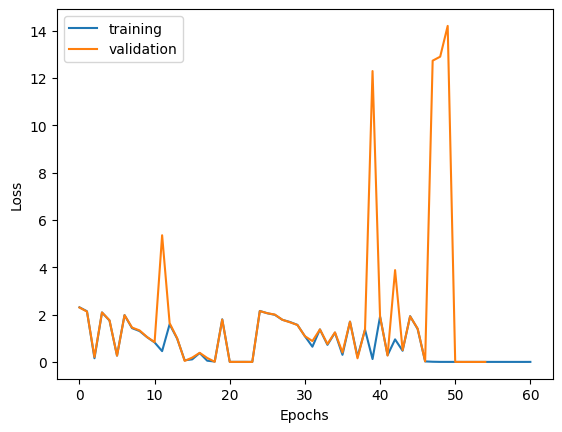

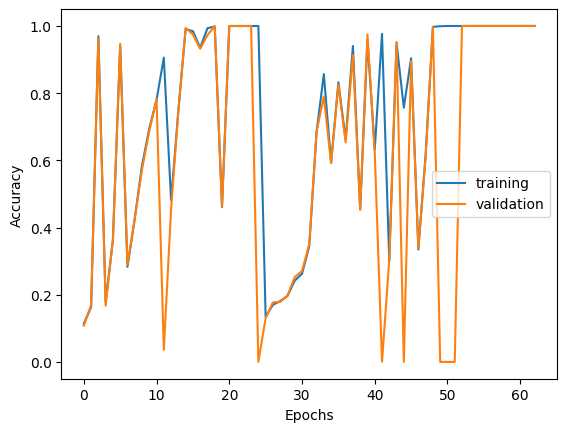

In [38]:
plt.figure()
plt.plot(new_list, label='training')
plt.plot(values, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(logdir + "/loss3.png")

plt.figure()
plt.plot(tr_acc_epoch, label='training')
plt.plot(val_acc_epoch, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(logdir + "/acc4.png")

In [21]:
val_loss_epoch1 = [0.5, 0.4, 0.6, 0.3, 0.7]  # Example list

# Create a copy of the original list
new_list = val_loss_epoch.copy()

# Find and remove the maximum element from the copied list
if new_list:  # Check if the list is not empty
    new_list.remove(max(new_list))

print("Original list:", val_loss_epoch)
print("New list without the max element:", new_list)


Original list: [0.5, 0.4, 0.6, 0.3, 0.7]
New list without the max element: [0.5, 0.4, 0.6, 0.3]


In [ ]:
a=tr

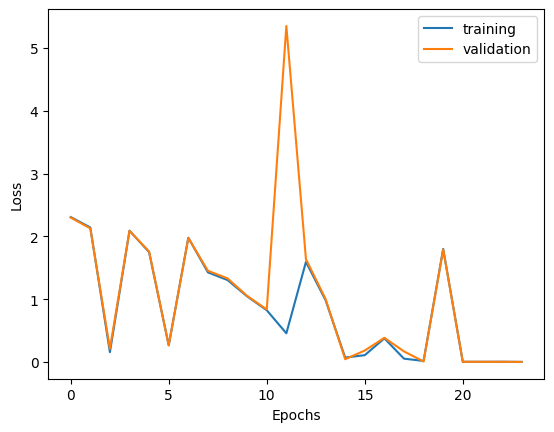

In [20]:
pr=tr_loss_epoch[0:24]
mr=val_loss_epoch[0:24]
plt.figure()
plt.plot(pr, label='training')
plt.plot(mr, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(logdir + "/loss1.png")



In [ ]:
# Plot NMI over epochs
plt.figure()
plt.plot(nmi_list, label='NMI over epochs')
plt.xlabel('Epoch')
plt.ylabel('NMI')
plt.title('NMI Stability Over Time')
plt.legend()
plt.show()

# Plot NMI over epochs
plt.figure()
plt.plot(nmi_list1, label='NMI over epochs')
plt.xlabel('Epoch')
plt.ylabel('NMI')
plt.title('NMI between true labels and cluster assignments over epochs')
plt.legend()
plt.show()

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    return accuracy

In [ ]:
accuracy = test()
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)